# Analysing Auction Performance
This notebook contains the code required to conduct a Bayesian data analysis on data collected from a set of multiple-lot online auction events executed in Europen markets, over the course of a year. We will build interpretable models of the average Return-on-Reserve (RoR), using variables that describe various facets of multiple-lot online auction events - e.g. the average number of bidders per-lot.

The ultimate aim of this endeavour is for this notebook (and it's surrounding directory structure) to serve as a template workflow for conducting an end-to-end Bayesian data analysis using PyMC3. It includes many helper functions for automating otherwise tedious tasks (e.g. interacting with Theano to score models on test data) and examples of how data pre-processing can be integrated with Scikit-Learn. The overall approach has been heavily inspired by the book 'Statistical Rethinking - a Bayesian Course with Examples in R and Stan', by Richard McElreath http://xcelab.net/rm/statistical-rethinking/, which is the most significant book on statistics and modelling that I have read during a career spanning more than a decade. Credit also goes to 'Bayesian Data Analysis', by Andrew Gelman & Co. http://www.stat.columbia.edu/~gelman/book/.

## Package Imports and Environment Setup

In [1]:
%matplotlib inline

import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder, FunctionTransformer)
from theano import shared

sns.set()
warnings.filterwarnings('ignore')

## Load Data and Yield Pandas DataFrame

We will be working with aggregated data from multiple-lot online auction events. An online auction event is comprised of multiple lots that are available for bidding on simultaneously and is usually time-boxed - e.g. the bidding on all lots is contained within a 2 week window.

We start by loading the auction data from a local CSV file and take a glimpse. In practice, the data need not be in CSV format and could be collected via Spark and then transformed to a Pandas DataFrame directly from a Spark DataFrame, etc.

In [2]:
auction_eval = pd.read_csv('../data/auction_data.csv')

auction_eval.info()
auction_eval.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 10 columns):
auction_id       6220 non-null int64
RoR              6220 non-null float64
STR              6220 non-null float64
BPL              6220 non-null float64
lots             6220 non-null int64
product_types    6220 non-null float64
avg_start_bid    6220 non-null float64
avg_reserve      6220 non-null float64
auction_mech     6220 non-null object
country          6220 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 486.0+ KB


,auction_id,RoR,STR,BPL,lots,product_types,avg_start_bid,avg_reserve,auction_mech,country
0,100,1.026112,0.503097,8.324074,108,0.768519,0.0,10568.250000,SealedBid,FR
1,101,1.407666,1.000000,5.571429,7,1.000000,0.0,4805.617249,EnglishForward,CZ
2,102,0.000000,0.000000,0.000000,2,1.000000,0.0,3550.000000,SealedBid,FR
3,103,0.884021,1.000000,1.000000,3,0.333333,0.0,7693.876790,FixedPrice,LU
4,104,0.972593,1.000000,4.533333,90,0.611111,0.0,8661.111111,EnglishForward,NL


### Data Description

- **auction_id** - unique identifier for a single multi-lot online auction event;
- **RoR** - the average Return-on-Reserve for lots that are sold successfully, where the return-on-reserve for a single lot is computed as its realised price divided by its reserve price;
- **STR** - the proportion of lots (by value) that were successfully sold in the auction event;
- **lots** - the number of lots offered in the auction event;
- **product_types** - the number of different product types offered in the auction event;
- **avg_reserve** - the average reserve price over all lots in the multi-lot online auction event
- **avg_start_bid** - the average starting-bid (expressed as a fraction of the reserve bid), over all lots in the auction event
- **BPL** - the average number of bidders per-lot;
- **auction_mech** - the auction mechanism used for the auction event (one of English Forward, Sealed Bid or Fixed Price); and,
- **country** - the local market running the auction.

### Initial Variable Selection

We choose the following variables to use for trying to understand and predict RoR:

- **lots** - with the aim for controlling for the presence of available alternatives;
- **avg_reserve** - to control for lot value - e.g. lower value lots may see more bidders willing to go above the reserve and vice-versa;
- **avg_start_bid** - to control for the presence of a public price signal (we may need to derive this);
- **BPL** - we know from basic auction theory, that the more bidders there are, then the better the expected prices will be;
- **auction_mech** - whether the lots were traded via English Forward (EF) or Sealed Bid (SB) auctions; and,
- **country** - to control for differences between local markets.

In [3]:
RoR = ['RoR']
model_vars = ['lots', 'avg_reserve', 'avg_start_bid',
              'BPL', 'auction_mech', 'country']

The section below explores the data in greater detail - to get straight to the modelling head to the section titles '**Modelling RoR using Bayesian Inference**'.

## Data Exploration

Through visualisation and descriptive statistics we try to understand the characteristics of the individual variables that are available for using to predict RoR.

### Descriptive Statistics

In [4]:
auction_eval[RoR + model_vars].head()

,RoR,lots,avg_reserve,avg_start_bid,BPL,auction_mech,country
0,1.026112,108,10568.250000,0.0,8.324074,SealedBid,FR
1,1.407666,7,4805.617249,0.0,5.571429,EnglishForward,CZ
2,0.000000,2,3550.000000,0.0,0.000000,SealedBid,FR
3,0.884021,3,7693.876790,0.0,1.000000,FixedPrice,LU
4,0.972593,90,8661.111111,0.0,4.533333,EnglishForward,NL


### Outlier Removal and other Dataset Filtering

We are aware that outliers have found their way into the data. So, we will limit our modeling dataset by filtering-out values that don't feel correct, based on our knowledge of the data (and the issues embedded within it). As such, we will filter-out the top percentile of RoR values as we know there is ambiguity surrounding reserve prices (the denomintator in computing the return-on-reserve for a single lot). Likewise, we have spotted auction events with average reserve prices in the millions of Euros, so we will filter-out the top percentile of mean reserve price observations, as well.

We will also exclude Fixed Price (FP) auction events from the dataset as the RoR for these auction events is fixed at 1 and all auction events where nothing was sold and nothing can be said about price and RoR (i.e. where auction revenue = 0).

In [5]:
ptile_thold = 0.99

model_data = (
    auction_eval
    .loc[
        (auction_eval['RoR'] > 0)
        & (auction_eval['auction_mech'] != 'FixedPrice')
        & (auction_eval['RoR'] < auction_eval['RoR'].quantile(ptile_thold))
        & (auction_eval['avg_reserve']
           < auction_eval['avg_reserve'].quantile(ptile_thold)), :]
    .assign(
        country=auction_eval['country'].apply(lambda x: 'country_' + x),
        auction_mech=(
            auction_eval['auction_mech'].apply(lambda x: 'auction_mech_' + x)))
    [RoR + model_vars])

desc_vars = ['auction_id']

model_data.describe()

,RoR,lots,avg_reserve,avg_start_bid,BPL
count,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.989743,48.491018,11099.072681,0.205143,4.997294
std,0.140135,39.081027,4910.386793,0.390067,2.653911
min,0.052569,1.000000,400.000000,0.000000,0.000000
25%,0.921498,17.000000,7378.053377,0.000000,2.885714
50%,1.000367,40.000000,10218.566667,0.000000,4.873239
75%,1.041915,74.000000,13731.054182,0.000000,6.764655
max,1.617087,516.000000,30198.234375,1.000000,20.000000


### RoR

Starting by reminding ourselves of the distributional characteristics of RoR (the data labels for our regression task).

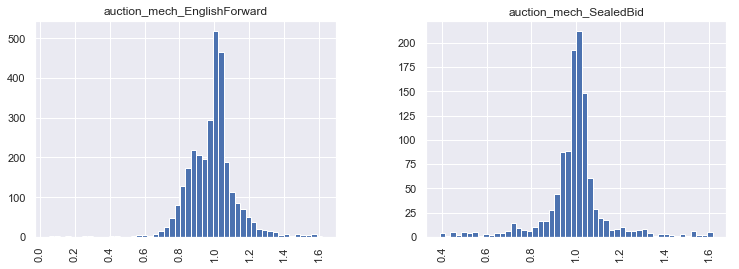

In [6]:
_ = (model_data[RoR + ['auction_mech']]
     .hist(by='auction_mech', bins=50, figsize=(12, 4)))

- EF auctions appear to have a bi-model distribution, suggesting conditioning on independent variables; and,
- SB auctions appear to have 'fat tails' - i.e. a Student-T likelihood function may be worth considering.

We now take a deeper look into EF auctions and the distribution of RoR by whether or not start bids were used.

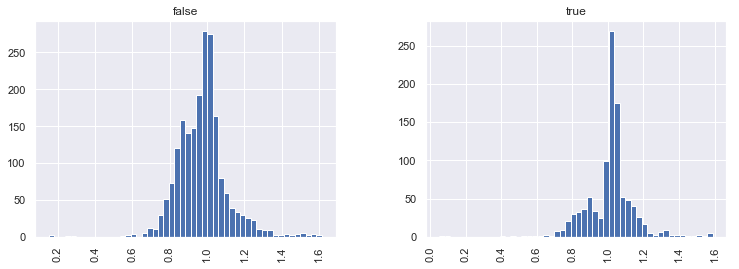

In [7]:
_ = (model_data
     .query('auction_mech == "auction_mech_EnglishForward"')
     .assign(has_start_bids=auction_eval['avg_start_bid']
             .apply(lambda x: 'true' if x > 0 else 'false'))
     [RoR + ['has_start_bids']]
     .hist(by='has_start_bids', bins=50, figsize=(12, 4)))

Some of the bi-modality in RoR does appear to originate from the presence of start bids (above left). This sub-distribution is, however, also bi-model so all of our question have not been answered. We continue to dig-in to this and look at a scatter plot of RoR vs. avg_start_bid to see if the magnitude of the start bids plays a part in what we are observing.

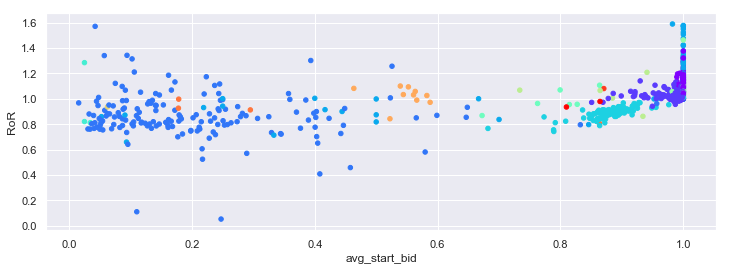

In [8]:
start_bid_analysis = (
    model_data
    .query('auction_mech == "auction_mech_EnglishForward"')
    .query('avg_start_bid > 0'))

_ = (start_bid_analysis
     .plot('avg_start_bid', 'RoR', kind='scatter',
           c=start_bid_analysis['country'].factorize()[0], cmap='rainbow',
           colorbar=False, figsize=(12, 4)))

Based on the above plot, it appears that there are some countries that are setting start bids that are greater-than-or-equal to the reserve price, which cannot be true. Thus, we will will filter-out these data points before we start modelling in earnest.

There are 261 observations with spurious start bid (and hence reserve
      price) data to filer-out.


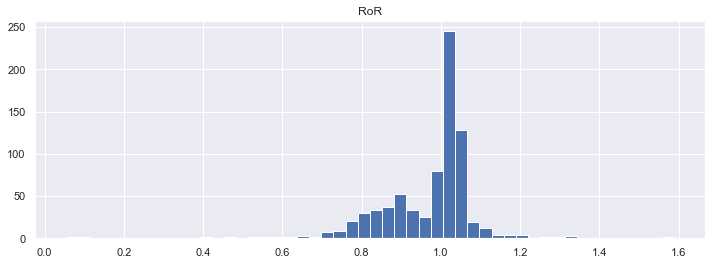

In [9]:
print("""There are {} observations with spurious start bid (and hence reserve
      price) data to filer-out."""
      .format(model_data.query('avg_start_bid >= 1').shape[0]))

_ = (start_bid_analysis
     .query('avg_start_bid < 1')
     [RoR]
     .hist(bins=50, figsize=(12, 4)))

We can, however, see from the filtered distribution above that the bi-modality is still present. With recourse to the scatter plot above, we can see that the bi-modality is country-related, which justifies the choice of country as a potential explanatory variable that we may need to control for (or condition on).

### Independent Variables (Features)

We now turn our attention to the distributional characteristics of each potential numerical modelling variable.

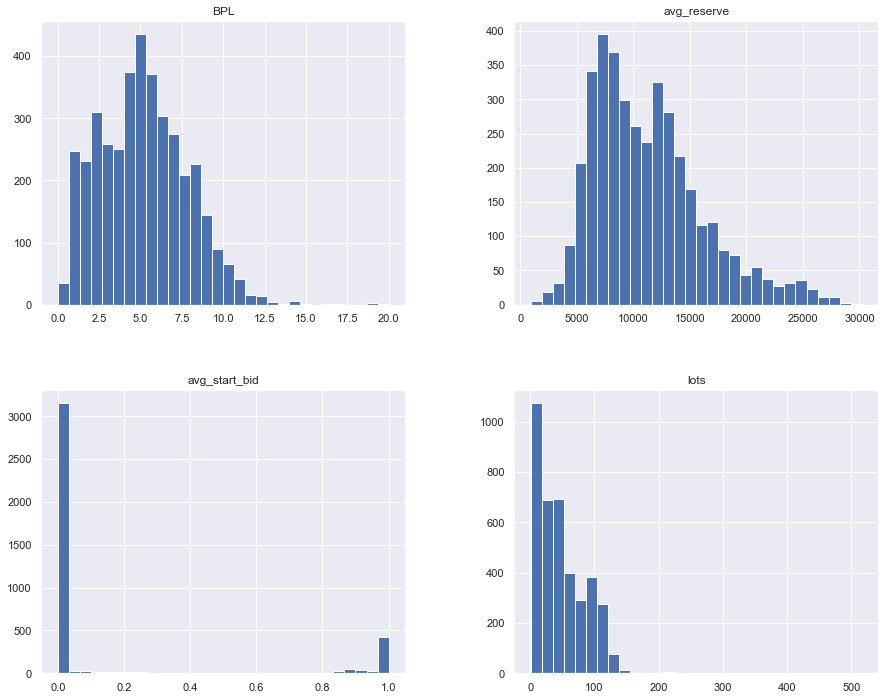

In [10]:
_ = (model_data[model_vars]
     .query('avg_start_bid < 1')
     .hist(bins=30, figsize=(15, 12)))

### Dependency Structure and Correlations
Taking a superficial look at variate-by-variate scatter plots and Pearson correlations between RoR and the initial modelling variables, for a single country ('EU' - the pan-European online market), and trading mechanism (English Forward). We have deliberately looked at a specific (conditioned) slice through the data as it will be representative of the kinds of models we will build using the categorical data and because visually, different relationships relating to the different market structures and dynamics associated with different entities and mechanisms, will not obfuscate any pattern.

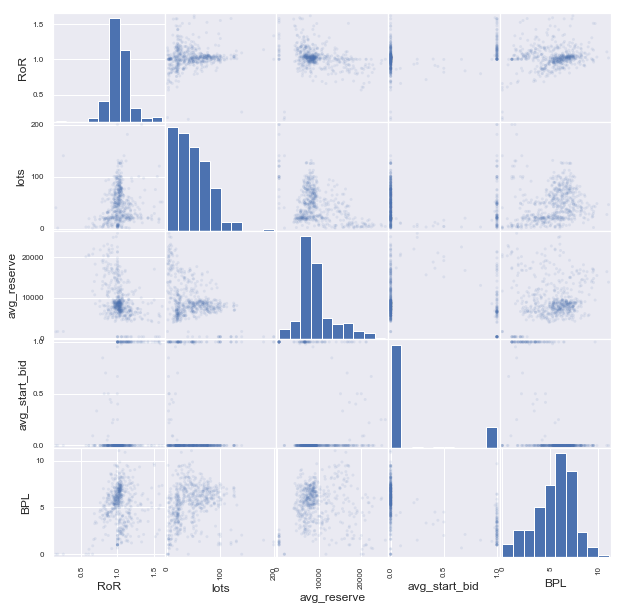

In [11]:
_ = pd.plotting.scatter_matrix(
    (model_data[RoR + model_vars]
     .query('country == "country_EU"')
     .query('auction_mech == "auction_mech_EnglishForward"')),
    figsize=(10, 10), alpha=0.1)

In [12]:
model_data[RoR + model_vars].corr()

,RoR,lots,avg_reserve,avg_start_bid,BPL
RoR,1.000000,0.069050,-0.072248,0.175049,0.210993
lots,0.069050,1.000000,-0.013865,0.365629,0.012851
avg_reserve,-0.072248,-0.013865,1.000000,-0.000236,-0.036440
avg_start_bid,0.175049,0.365629,-0.000236,1.000000,-0.497484
BPL,0.210993,0.012851,-0.036440,-0.497484,1.000000


Initial thoughts on the choice of modelling variables:
- **avg_start_bid** should be mapped to a categorical variable 'has_start_bid' as it is almost binary;
- neglecting **avg_start_bid**, there doesn't appear to be any obvious sources of multi-collinearity - via 'post-treatment bias', or otherwise - that could interfere with model interpretation .

## Modelling RoR using Bayesian Inference
Whereas in the past we have trained multiple ML algorithms when the ultimate aim was prediction, we are currently focused more on statistical learning, model interpretation and modelling real-world economic phenomena - than we are on prediction accuracy. Hence, we will concentrate our efforts on using a single approach - estimating linear regression models using Bayesian inference techniques.

### Data Preparation Pipeline
We define data transformation pipelines to:
- select the variables of interest;
- center and scale the continuous variables; 
- handling categorical features in a way that makes sense for our models - e.g. encoding factors (or levels) as opposed to one-hot encoding; and,
- use a log-transform on the dependent variable (using a separate pipleine for this variable as in production we would be predicting this variable and would not have access to it).

The motivation for centering and scaling the data is threefold:
1. the numerical routines required for computing MAP estimates and posterior distribution samples are more stable when all of the input variates have the same scale (i.e. the same units);
2. centering the variates so that the mean level corresponds to 0 makes it easy to isolate the impact that just one independent variable (e.g. lots), has on the dependent variable (i.e. RoR), by setting all other variables to 0 (i.e. their mean level); and,
3. both centering and scaling the variables by the standard deviation leads to easy interpretation and comparison of parameters estimates - e.g a parameter estimate is 1, then we know that when the independent variable (e.g. lots), is 1 standard deviation above the mean, then it will impact the dependent variable (i.e. RoR), by precisely 1.

The motivation for using a log-transform:
- RoR is bounded in the range $(0, \infty]$, by construction;
- we intend to use maximum entropy distributions (e.g. Normal) as likelihood functions, but these are defined with support on $[-\infty, \infty]$; so,
- by defining the following transformation of RoR, $y = f(\text{RoR}) =  \ln(\text{RoR})$, we can use a maximum entropy distributions as likelihood functions, with confidence that they are correctly expressing the uncertainty in the transformed dependent variable, $y$.

In [13]:
def cat_col_selector(df):
    df_cat = df.select_dtypes(include=['object'])
    return df_cat.values


def num_col_selector(df):
    df_num = df.select_dtypes(exclude=['object'])
    return df_num.values


def cat_col_str2fact(X):
    fact_cols = [LabelEncoder().fit_transform(col) for col in X.T]
    fact_mat = np.vstack(fact_cols)
    return fact_mat.T


def cat_col_fact_names(df):
    def list_of_fact_names(col):
        fact_names = LabelEncoder().fit(col).classes_
        return fact_names.tolist()
    df_cat = df.select_dtypes(include=['object'])
    X = df_cat.values
    fact_name_cols = [(col_name, list_of_fact_names(col))
                      for col_name, col in zip(df_cat.columns, X.T)]
    return dict(fact_name_cols)


def make_new_vars(df):
    start_bid_map = (
        lambda x: 'start_bids_true' if x > 0 else 'start_bids_false')
    new_df = df.assign(start_bids=df['avg_start_bid'].apply(start_bid_map))
    return new_df


# pipline for independent variables
feature_data_pipe = Pipeline([
    ('make_new_vars', FunctionTransformer(make_new_vars, validate=False)),
    ('union', 
     FeatureUnion([
        ('num_vars', 
         Pipeline([
            ('get_num_vars',
             FunctionTransformer(num_col_selector, validate=False)),
            ('scale_vars', StandardScaler())
         ])),
        ('cat_vars', 
         Pipeline([
            ('get_cat_vars',
             FunctionTransformer(cat_col_selector, validate=False)),
            ('factorise',
             FunctionTransformer(cat_col_str2fact, validate=False))
         ]))
     ])
    )
])

# piplines for dependent variable
label_data_pipe = Pipeline([
    ('log', FunctionTransformer(np.log, np.exp, validate=False))])

label_itfm = label_data_pipe.inverse_transform

# get variable names
num_var_names = (
    make_new_vars(model_data[model_vars])
    .select_dtypes(exclude=['object'])
    .columns
    .tolist())

cat_var_names = (
    make_new_vars(model_data[model_vars])
    .select_dtypes(include=['object'])
    .columns
    .tolist())

all_var_names = num_var_names + cat_var_names

# get levels for categorical data
cat_col_levels = cat_col_fact_names(make_new_vars(model_data[model_vars]))

# perform transformations
y = (label_data_pipe
     .fit_transform(model_data['RoR'])
     .values
     .reshape(-1, ))

X = (feature_data_pipe
     .fit_transform(model_data[model_vars]))

X_df = pd.DataFrame(X, columns=all_var_names)
X_df.head()

,lots,avg_reserve,avg_start_bid,BPL,auction_mech,country,start_bids
0,1.522890,-0.108115,-0.525979,1.253689,1.0,10.0,0.0
1,-1.061794,-1.281815,-0.525979,0.216361,0.0,5.0,0.0
2,1.062253,-0.496550,-0.525979,-0.174842,0.0,18.0,0.0
3,0.985481,-1.225603,2.037988,-0.714990,0.0,16.0,1.0
4,-0.933839,-1.441667,-0.525979,-0.281616,0.0,5.0,0.0


### Partition Data into Test and Train Sets
We select 20% of the available observations to hold-back from training our model on, so that their out-of-sample performance can be tested along side other measures of Out-Of-Sample (OOS) predictive accuracy, such as WAIC.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print('{} samples in training dataset and {} samples in test dataset'
      .format(X_train.shape[0], X_test.shape[0]))

3340 samples in training dataset and 835 samples in test dataset


### Define Experimental Setup
In addition to assessing competing models using Bayesian information criteria (e.g. WAIC), we would also like to understand the Root-Mean-Squared-Error (RMSE) of RoR predictions, both in-sample and out-of-sample (due to its ubiquitous use in machine learning model evaluation). The helper function below facilitates this analysis. 

In [22]:
def model_performance(y_, trace_, model_, samples_=500, intvl=0.95,
                      y_inv_tfm=None):

    # if no inverse has been provided use identity
    f = (lambda x: x) if y_inv_tfm is None else y_inv_tfm

    # compute two-sided percentiles for range
    intvl_lwr = (1 - intvl) / 2
    intvl_upr = intvl_lwr + intvl

    # generate samples from the posterior predictive distribution
    # use the expected value as the final prediction
    post_pred_samp = pm.sample_posterior_predictive(
        trace_, model=model_, samples=samples_, random_seed=42)
    
    pred = f(post_pred_samp['obs'].mean(axis=0))

    # compute prediction ranges
    pred_range_lwr = np.percentile(
        f(post_pred_samp['obs']), 100*intvl_lwr, axis=0)
    pred_range_upr = np.percentile(
        f(post_pred_samp['obs']), 100*intvl_upr, axis=0)

    # compute error on model scale
    actual = f(y_)
    error = pred - actual

    # compute deviance using lppd
    waic = pm.stats.waic(trace_, model_, progressbar=True)
    deviance = waic.WAIC - waic.p_WAIC

    # observations in prediction range
    in_range = ((actual > pred_range_lwr)
                & (actual < pred_range_upr)).astype('int')

    # assemble results
    performance_data = np.concatenate([
        pred.reshape((-1, 1)), actual.reshape((-1, 1)), error.reshape((-1, 1)),
        pred_range_lwr.reshape((-1, 1)), pred_range_upr.reshape((-1, 1)),
        in_range.reshape((-1, 1))],
        axis=1)

    # print metrics and return
    print('RMSE = {}'.format(np.sqrt(np.mean(error ** 2))))
    print('Deviance = {}'.format(deviance))
    print('% observations in {}% prediction range = {}'
          .format(100 * intvl, 100 * np.sum(in_range) / in_range.shape[0]))

    df = pd.DataFrame(
        performance_data,
        columns=['predicted', 'actual', 'error', 'predicted_lwr',
                 'predicted_upr', 'in_range'])
    return df

### Map Data to Model Variables
To make the model specification easier to read and to facilitate prediction with PyMC3, we explicitly map data columns to their own name. We also explicitly define them as variables in Theano, whose values can be changed, for example, when need to load test data after estimating on training data (see http://docs.pymc.io/notebooks/posterior_predictive.html for more). We provide two helper functions for these purposes.

In [16]:
def load_test_data():
    y.set_value(y_test)
    lots.set_value(X_test[:, 0])
    mean_rsv.set_value(X_test[:, 1])
    avg_start_bid.set_value(X_test[:, 2])
    BPL.set_value(X_test[:, 3])
    auction_mech.set_value(X_test[:, 4].astype('int32'))
    country.set_value(X_test[:, 5].astype('int32'))
    start_bids.set_value(X_test[:, 6].astype('int32'))
    return None


def load_train_data():
    y.set_value(y_train)
    lots.set_value(X_train[:, 0])
    mean_rsv.set_value(X_train[:, 1])
    avg_start_bid.set_value(X_train[:, 2])
    BPL.set_value(X_train[:, 3])
    auction_mech.set_value(X_train[:, 4].astype('int32'))
    country.set_value(X_train[:, 5].astype('int32'))
    start_bids.set_value(X_train[:, 6].astype('int32'))
    return None


y = shared(y_train)
lots = shared(X_train[:, 0])
mean_rsv = shared(X_train[:, 1])
avg_start_bid = shared(X_train[:, 2])
BPL = shared(X_train[:, 3])
auction_mech = shared(X_train[:, 4].astype('int32'))
country = shared(X_train[:, 5].astype('int32'))
start_bids = shared(X_train[:, 6].astype('int32'))

n_country = len(set(X_df['country'].tolist()))
n_mech = len(set(X_df['auction_mech'].tolist()))

### Handling MCMC Simulation and Persisting Computed Chains to Disk
If we expend compute-time on running MCMC simulations to evaluate our models, we do not want this to be wasted if we want to re-run a notebook with the models as-is (e.g we add new model and we want to compare WAIC against previous models). To facilitate this efficiency we define a function for persisting the chains to disk and only re-computing them if the number of 'draws' or 'tune' steps has changed (or we have explicitly asked it to).

In [17]:
def run_or_load_mcmc(model_, draws_=1000, tune_=500, parallel_chains=2,
                     path='../results/', force_rerun=False):

    model_str = [k for k, v in globals().items() if v is model_][0]

    path_to_filname = (
        path + model_str + '_tune' + str(tune_) + "draw" + str(draws_)
        + 'chains' + str(parallel_chains) + '.pkl')

    with model_:
        try:
            if force_rerun:
                raise Exception('forcing MCMC re-run')
            print('loading traces from: ' + path_to_filname)
            trace_ = joblib.load(path_to_filname)
        except:
            print('computing traces...')
            trace_ = pm.sample(draws=draws_, tune=tune_, njobs=parallel_chains)
            joblib.dump(trace_, path_to_filname, compress=9)
            print('saving traces to: ' + path_to_filname)

    return trace_

### Model Specification #1 - Weakly Regularising Priors and Normal Likelihood
We start by defining a simple and pragmatic linear model and then estimate it with both MAP and MCMC methods. We have chosen the mean and standard deviation (StdDev) of the priors such that there is a very low probability that a 1 StdDev change in an independent variable impacts the dependent variable, $\ln(\text{RoR})$, by 1 (or RoR by, $e^1 = 2.72$).  

We have chosen Normal priors on the parameter estimates to reflect maximal uncertainty (i.e. Entropy) under the constraint of having a fixed mean and variance, while of the prior on sigma we have deliberately chosen a non-flat but weakly regularising prior for the benefit of efficient MCMC estimation.

In [18]:
load_train_data()

with pm.Model() as ror_basic:

    # priors for unknown model parameters
    alpha_country = pm.Normal('alpha_country', mu=0, sd=0.25, shape=n_country)
    alpha_mech = pm.Normal('alpha_mech', mu=0, sd=0.25, shape=n_mech)
    alpha_start_bids = pm.Normal('alpha_start_bids', mu=0, sd=0.25, shape=2)

    beta_lots = pm.Normal('beta_lots', mu=0, sd=0.25, shape=1)
    beta_mean_rsv = pm.Normal('beta_mean_res', mu=0, sd=0.25, shape=1)
    beta_BPL = pm.Normal('beta_BPL', mu=0, sd=0.25, shape=1)

    sigma = pm.HalfCauchy('sigma', beta=2)

    # expected value
    mu = (alpha_country[country] + alpha_mech[auction_mech]
          + alpha_start_bids[start_bids]
          + beta_lots[0] * lots + beta_mean_rsv[0] * mean_rsv
          + beta_BPL[0] * BPL)

    # likelihood (sampling distribution) of observations
    pm.Normal('obs', mu=mu, sd=sigma, observed=y)

#### Markov Chain Monte Carlo Model Estimation
To get better diagnostics, we use Markov Chain Monte Carl (MCMC) techniques to simulate draw samples from the posterior distribution.

In [19]:
# ror_model_basic_trace = run_or_load_mcmc(
#     ror_model_basic, draws_=10000, tune_=2500)

ror_basic_trace = run_or_load_mcmc(ror_basic, draws_=1000, tune_=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


loading traces from: ../results/ror_basic_tune500draw1000chains2.pkl
computing traces...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_BPL, beta_mean_res, beta_lots, alpha_start_bids, alpha_mech, alpha_country]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:37<00:00, 19.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


saving traces to: ../results/ror_basic_tune500draw1000chains2.pkl


We use a forest plot to visualise credible intervals and MCMC diagnostics for the model. Given the number of variables in the model, we have opted against using tables of summary data and trace plots.

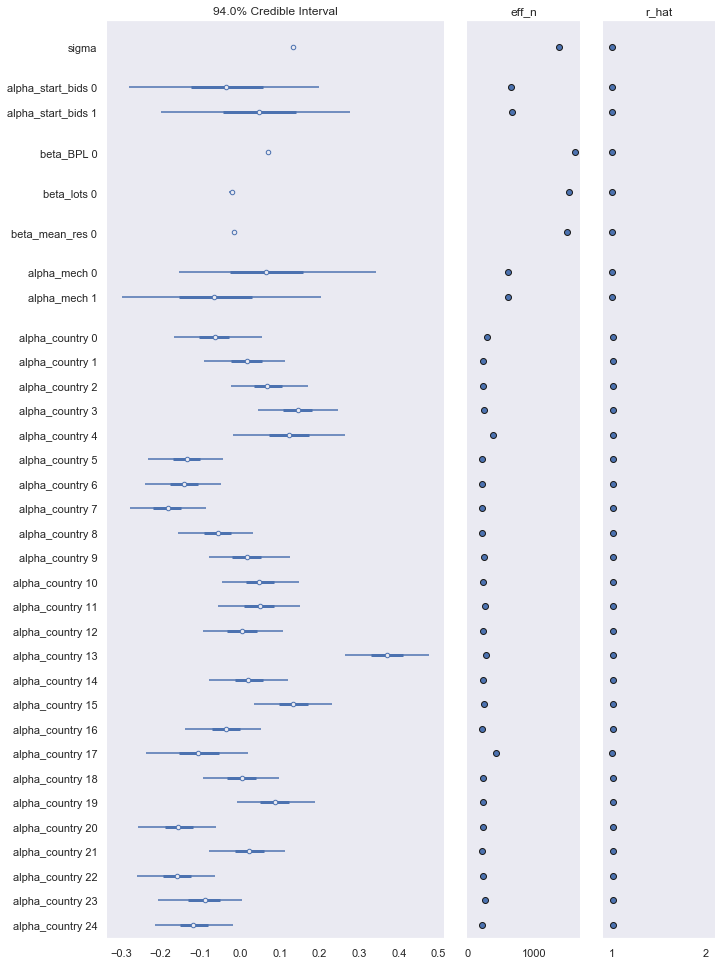

In [20]:
_ = az.plot_forest(ror_basic_trace, r_hat=True, eff_n=True, combined=True)

Values of the Gelman-Rubin statistic (r_hat) are close to 1 and the the effective number of draws for each marginal parameter distribution (eff_n) are acceptible. Thus, we have confidence that the MCMC algorithm has successfully inferred (or explored) the posterior distribution for our chosen probabilistic program. We now take a closer look at MCMC traces.

#### In-Sample Prediction
Simulate predictions of alpha from the posterior distribution, conditional on observations of the input variables (as held within ror_model_basic). We do this for predictions both on 'model' and 'inverse transformed' values.

100%|██████████| 10000/10000 [01:51<00:00, 89.30it/s]
2000it [00:00, 6811.17it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RMSE = 0.1314998768113714
Deviance = -4040.0320127355503
% observations in 95.0% prediction range = 95.59880239520957


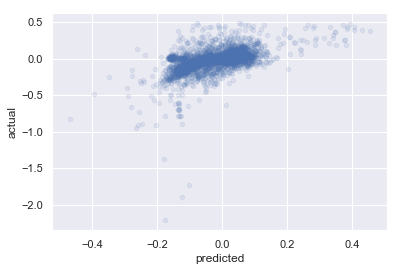

In [23]:
ror_basic_insamp = model_performance(
    y_train, ror_basic_trace, ror_basic, samples_=10000)

_ = (ror_basic_insamp
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1))

As above, but applying the inverse transform to the model's prediction to get to the 'natural' scale.

100%|██████████| 10000/10000 [01:52<00:00, 88.96it/s]
2000it [00:00, 4665.53it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RMSE = 0.11590624360304666
Deviance = -4040.0320127355503
% observations in 95.0% prediction range = 95.59880239520957


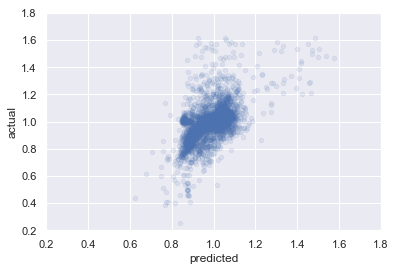

In [24]:
ror_basic_insamp_tfm = model_performance(
    y_train, ror_basic_trace, ror_basic, samples_=10000,
    y_inv_tfm=label_itfm)

_ = (ror_basic_insamp_tfm
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1,
           xlim=[0.2, 1.8], ylim=[0.2, 1.8]))

The model shows some great performance, but with some terrible estimates as well. We now take a look at the residuals on the 'model' scale, as a check to ensure that our choice of likelihood function was adequate and that there is no obvious multi-modality that may be due to a lack of informative independent variables to condition on.

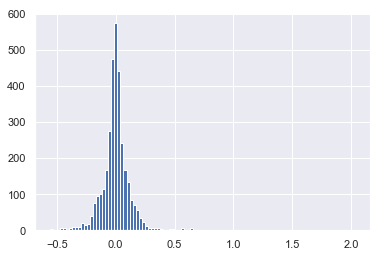

In [25]:
_ = (ror_basic_insamp['error']
     .hist(bins=100))

Looks like a nice Student-T distribution would better approximate the 'fat tails' we can see here.

#### Out-of-Sample Prediction

100%|██████████| 10000/10000 [01:49<00:00, 91.44it/s]
2000it [00:00, 8827.29it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RMSE = 0.11785780315819314
Deviance = -672.9644131459627
% observations in 95.0% prediction range = 95.80838323353294


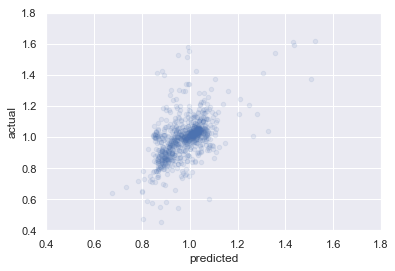

In [26]:
load_test_data()

ror_basic_outsamp = model_performance(
    y_test, ror_basic_trace, ror_basic, samples_=10000,
    y_inv_tfm=label_itfm)

_ = (ror_basic_outsamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.4, 1.8],
           ylim=[0.4, 1.8], alpha=0.1))

### Model Specification #2 - Weakly Regularising Priors and Robust Estimation
We adapt our basic model to use a Student-T likelihood for robustness / 'fat tails', with the same weakly regularising priors as for model #1. We have chosen a parametrisation for the degrees of freedom, $\nu$, that allows us to explore all possible values using only a small uniform interval. This will improve the performance of the Hamiltonian Monte Carlo (HMC) algorithm used to generate the Markov chains, by defending against the vanishing gradients along this dimension of the posterior distribution.

In [27]:
load_train_data()

with pm.Model() as ror_robust:

    # priors for unknown model parameters
    alpha_country = pm.Normal('alpha_country', mu=0, sd=0.25, shape=n_country)
    alpha_mech = pm.Normal('alpha_mech', mu=0, sd=0.25, shape=n_mech)
    alpha_start_bids = pm.Normal('alpha_start_bids', mu=0, sd=0.25, shape=2)

    beta_lots = pm.Normal('beta_lots', mu=0, sd=0.25, shape=1)
    beta_mean_rsv = pm.Normal('beta_mean_res', mu=0, sd=0.25, shape=1)
    beta_BPL = pm.Normal('beta_BPL', mu=0, sd=0.25, shape=1)

    tau = pm.Uniform('tau', lower=0, upper=1)
    sigma = pm.HalfCauchy('sigma', beta=2)

    # expected value
    mu = (alpha_country[country] + alpha_mech[auction_mech]
          + alpha_start_bids[start_bids] + beta_lots[0] * lots
          + beta_mean_rsv[0] * mean_rsv + beta_BPL[0] * BPL)

    # likelihood (sampling distribution) of observations
    pm.StudentT('obs', mu=mu, sd=sigma, nu=1/tau, observed=y)

#### Markov Chain Monte Carlo Model Estimation
To get better diagnostics, we use Markov Chain Monte Carl (MCMC) techniques to simulate draw samples from the posterior distribution.

In [28]:
# ror_robust_trace = run_or_load_mcmc(ror_robust, draws_=10000, tune_=2500)

ror_robust_trace = run_or_load_mcmc(ror_robust, draws_=1000, tune_=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


loading traces from: ../results/ror_robust_tune500draw1000chains2.pkl
computing traces...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, beta_BPL, beta_mean_res, beta_lots, alpha_start_bids, alpha_mech, alpha_country]
Sampling 2 chains: 100%|██████████| 3000/3000 [06:00<00:00,  3.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


saving traces to: ../results/ror_robust_tune500draw1000chains2.pkl


We use a forest plot to visualise credible intervals and MCMC diagnostics for the model. Given the number of variables in the model, we have opted against using tables of summary data and trace plots.

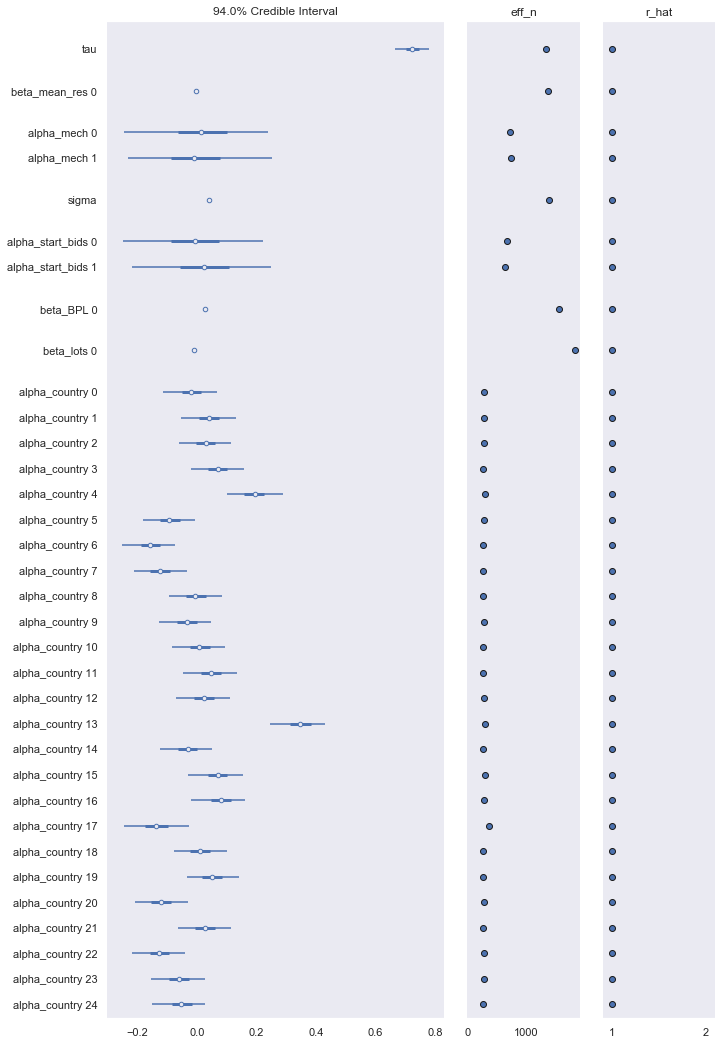

In [29]:
_ = az.plot_forest(ror_robust_trace, r_hat=True, eff_n=True, combined=True)

Values of the Gelman-Rubin statistic (r_hat) are close to 1 and the the effective number of draws for each marginal parameter distribution (eff_n) are acceptible. Thus, we have confidence that the MCMC algorithm has successfully inferred (or explored) the posterior distribution for our chosen probabilistic program. We now take a closer look at MCMC traces.

#### In-Sample Prediction
Simulate predictions of alpha from the posterior distribution, conditional on observations of the input variables (as held within ror_model_robust), as before.

100%|██████████| 10000/10000 [01:53<00:00, 88.13it/s]
2000it [00:00, 4531.27it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RMSE = 0.1430487364634711
Deviance = -6274.800414571081
% observations in 95.0% prediction range = 95.50898203592814


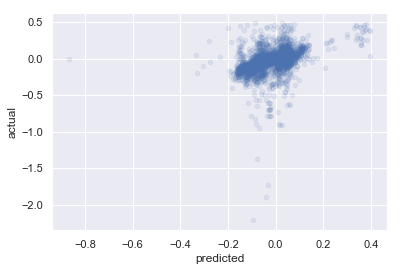

In [30]:
ror_robust_insamp = model_performance(
    y_train, ror_robust_trace, ror_robust, samples_=10000)

_ = (ror_robust_insamp
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1))

As above, but applying the inverse transform to the model's prediction to get to the 'natural' scale.

100%|██████████| 10000/10000 [01:55<00:00, 92.53it/s]
2000it [00:00, 4574.15it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RMSE = 0.12421056899505112
Deviance = -6274.800414571081
% observations in 95.0% prediction range = 95.50898203592814


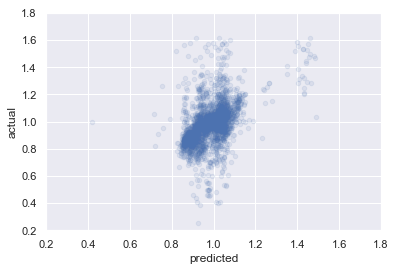

In [31]:
ror_robust_insamp_tfm = model_performance(
    y_train, ror_robust_trace, ror_robust, samples_=10000,
    y_inv_tfm=label_itfm)

_ = (ror_robust_insamp_tfm
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1,
           xlim=[0.2, 1.8], ylim=[0.2, 1.8]))

We take a look at the residuals again, just because it makes me comfortable.

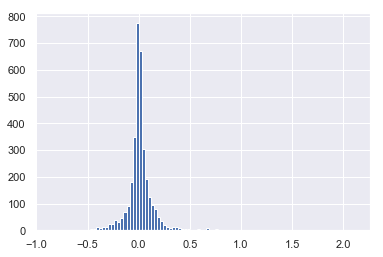

In [32]:
_ = (ror_robust_insamp['error']
     .hist(bins=100))

Looks like a nice Student-T distribution, just as we specified in our model! We now use the model to score the test dataset.

#### Out-of-Sample Prediction

100%|██████████| 10000/10000 [01:46<00:00, 93.81it/s]
2000it [00:00, 7185.72it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RMSE = 0.1275120199601781
Deviance = -1527.7033245799712
% observations in 95.0% prediction range = 95.08982035928143


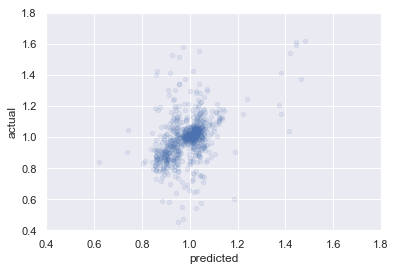

In [33]:
load_test_data()

ror_robust_outsamp = model_performance(
    y_test, ror_robust_trace, ror_robust, samples_=10000,
    y_inv_tfm=label_itfm)

_ = (ror_robust_outsamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.4, 1.8],
           ylim=[0.4, 1.8], alpha=0.1))

## Model Comparison

We start by comparing marginal parameter distributions usinga side-by-side forest plot.

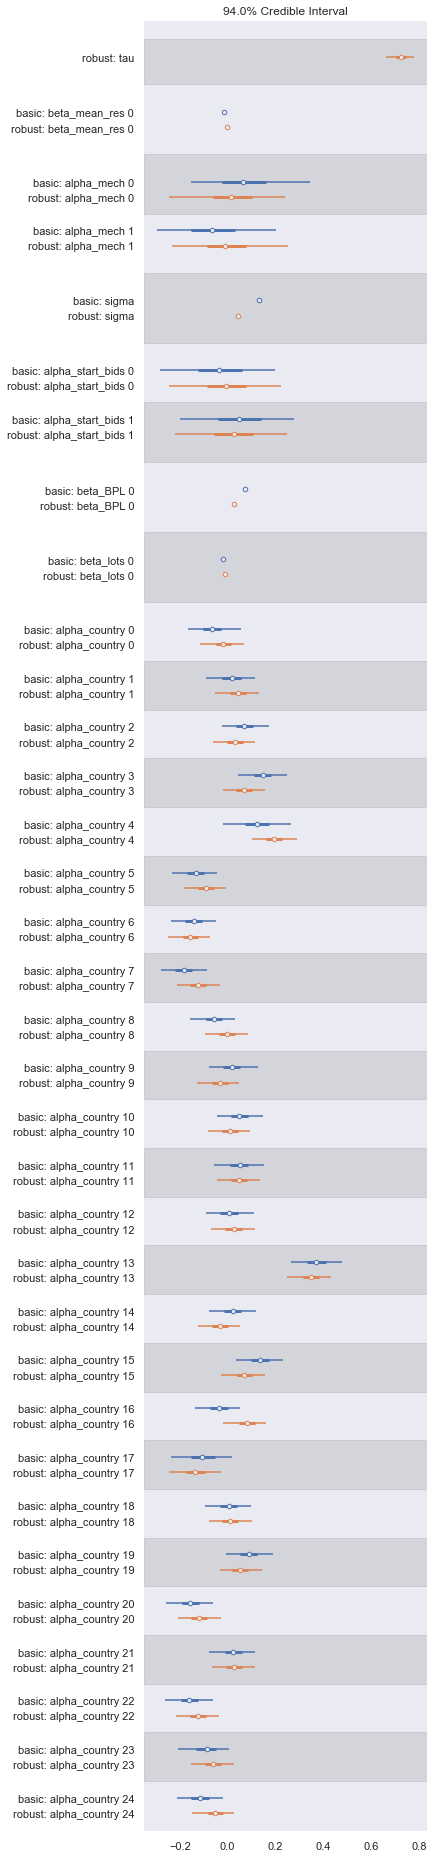

In [34]:
_ = az.plot_forest(
    data=[ror_basic_trace, ror_robust_trace], model_names=['basic', 'robust'],
    combined=True)

And we note that both models estimate marginal parameter distributions are *largely* in-line with one-another.

### Model Selection

We now use WAIC to help select which model to choose for subsequent interpretation. WAIC estimates the OOS predictive accuracy of a model (also known as the deviance), using only the training data. We are also in the fortunate position that we have a test dataset that we can use in addition to WAIC (to compute the actual OOS deviance).

Unlike other Bayesian information criteria (such as AIC and DIC) - that are based on an asymptotic Normal approximation of the posterior density - WAIC should be suitable for comparing models with different likelihood functions. See Chapter 7 of 'Bayesian Data Analysis', by Andrew Gelman & Co. for more discussion.

,waic,pwaic,dwaic,weight,se,dse,warning
robust,-6225.93,48.8749,0,0.805268,159.887,0,1
basic,-3992.46,47.5753,2233.47,0.194732,379.135,347.483,1


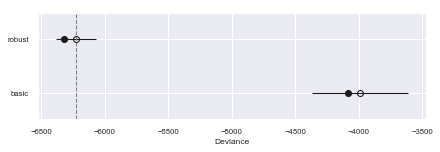

In [35]:
load_train_data()

comparison = az.compare({'basic': ror_basic_trace, 'robust': ror_robust_trace})

az.plot_compare(comparison, plot_ic_diff=False)
comparison

### Model Selection and Interpretation

The model with the lowest WAIC is the robust linear model. Furthermore, its actual OOS predictive performance, as measured by the OOS deviance, agrees with predicted OOS deviance as represented by WAIC. Perhaps most importantly, however, the distribution of the residuals are clearly leptokurtic, something which the Normal likelihood of the basic model cannot capture. To add to the weight of evidence for the robust model, we note that the Normal likelihood is a limiting case of the Student-T, as $\nu \to \infty$, and that **all** of the probability mass/density for $\nu$ is < 2. 

We now need transform the parameter estimates back to the natural scales of the data and compute the sensitivities of the dependent variable to changes (deltas) in the independent variables. We do this for each independent variable at a time, holding all other variables at their average levels (which is equivalent to setting them to zero as they have been standardised). 

Because we took the modelling decision to transform the dependent variable using the natural logarithm, the process of computing sensitivities for the polynomial model is not as trivial as it would have be otherwise. More specifically, a small change in the average level of an independent variable, has a measurable change to the *arithmetic return* of the independent variable, as we will derive below. 

Furthermore, because we have selected a model that uses the Student-T distribution as the likelihood function, there are further complications when it comes to computing means and variances - i.e. they are not well-defined for $\nu < 1$ and $\nu < 2$, respectively. Consequently, we will proceed by analogue with the Normal distribution - i.e. by computing means and variances as if, $\ln[RoR] \sim N(\mu, \sigma^2)$, and then mapping $\mu$ and $\sigma$ to account for the non-central Student-T distribution, [as described here](https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_σ,_or_σ2).

We start with the expression for the expected value of RoR in the presence of a $\Delta z_i$ change in the *i*-th standardised independent variable,

$$
\text{E}[RoR_{\Delta z_i}] = exp \left\{ C + \frac{\bar{\sigma}^2}{2} + \sum_j \beta_j \cdot (z_j + \delta_{ji} \cdot \Delta z_i) \right\}
$$

where,

$$
\bar{\sigma} = \sigma \cdot \sqrt{\frac{\nu}{\nu - 2}}
$$

And where $C$ is equal to the sum of all constant (or intercept) terms in our model. We can now show that the impact of a $\Delta z_i$ perturbation in $\text{E}[RoR]$, can be expressed as an arithmetic return as follows,

$$
r^{\text{RoR}}_{\Delta z_i} = \frac{\text{E}[RoR]_{\Delta z_i}}{\text{E}[RoR]} - 1 = exp \left\{ \beta_i \cdot \Delta z_i \right\} - 1
$$

i.e. all the constant terms cancel out (something that extends to any centring terms that may be present when applying the inverse of a standard scaling operation). We can now approximate $r^{\text{RoR}}_{\Delta z_i} = f(\Delta z_i)$, using a Taylor expansion, assuming that $|\beta_i \Delta z_i| < 1$,

$$
f(\Delta z) = \sum_{n = 0}^{\infty} \frac{(\Delta z)^n}{n!} \cdot \left( \frac{\partial f(q^{'})}{\partial q^{'}} \right)_{q^i = 0}
$$

If we only keep linear (first order) terms in $\Delta z$, then we have that,

$$
r^{\text{RoR}}_{\Delta z_i} \approx \beta \cdot \Delta z = \frac{\beta \cdot \Delta x}{\sigma_x}
$$

Where we have applied the inverse of the variable standardisation transformation (note, that this relationship holds irrespective of whether or not centring has been applied as well as scaling). 

In [36]:
num_var = ['lots', 'avg_reserve', 'BPL']

param_names = (
    cat_col_levels['country']
    + cat_col_levels['auction_mech']
    + cat_col_levels['start_bids']
    + num_var
    + ['nu', 'sigma'])

param_est = az.summary(ror_robust_trace)
param_est.index = param_names

param_est['std'] = np.hstack(
    [np.ones(29), model_data[num_var].std(), np.ones(2)])

param_est['delta_nat_unit'] = np.hstack(
    [np.ones(29), np.array([100, 1000, 1], dtype='float32'), np.zeros(2)])

param_est['delta_impact_pct'] = (
    100 * param_est['mean'] * param_est['delta_nat_unit'] / param_est['std'])

param_est['delta_impact_pct'] = (
    param_est['delta_impact_pct'].apply(lambda x: '{0:.2f}%'.format(x)))

results = param_est.drop(['sd', 'eff_n', 'r_hat', 'mc error'], axis=1)
results


,mean,hpd 3%,hpd 97%,std,delta_nat_unit,delta_impact_pct
country_AE,-0.02,-0.11,0.07,1.000000,1.0,-2.00%
country_AT,0.01,-0.08,0.09,1.000000,1.0,1.00%
country_BE,0.05,-0.05,0.13,1.000000,1.0,5.00%
country_BR,0.02,-0.07,0.11,1.000000,1.0,2.00%
country_CH,0.35,0.25,0.43,1.000000,1.0,35.00%
country_CZ,-0.03,-0.12,0.05,1.000000,1.0,-3.00%
country_DE,0.07,-0.03,0.15,1.000000,1.0,7.00%
country_ES,0.08,-0.02,0.16,1.000000,1.0,8.00%
country_EU,-0.14,-0.25,-0.03,1.000000,1.0,-14.00%
country_FI,0.01,-0.08,0.10,1.000000,1.0,1.00%


### Model Interrogation
Now that we have chosen a model that we believe is the most representative of the processes that led to the observed data, we can exploit the fact that this model is a *generative* model of these processes, start to ask detailed questions of it and stop relying on analyses of point estimates to answer complicated questions that these sorts of approximative analyses cannot address completely.

#### Analysis #1 - English Forward vs. Sealed Bid Auctions A/B Test
The first question that we will ask, are English Forward (EF) auction mechanisms perform better than Sealed Bid (SB) auction mechanisms. We already know that the *mean* (point estimates) of the EF and SB factors imply that EF auctions out-perform SB auctions *on average*, but these can only be taken at fact-value if there is correlation between the parameters (remember, these are also random variables). As we are now in a position to explicitly compute the differences and factor-in any dependency structure, we proceed with this approach.

P(EF-effect > SB-effect) = 0.9985
mean difference in RoR between EF and EB auctions = 0.02518745084935702


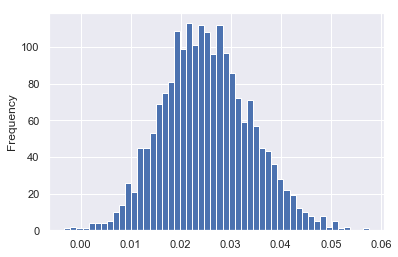

In [37]:
auction_mech_ab = pd.DataFrame(
    ror_robust_trace['alpha_mech'], columns=['EF', 'SB'])

auction_mech_ab['diff'] = (
    label_itfm(auction_mech_ab['EF']) - label_itfm(auction_mech_ab['SB']))

prob_EF_gt_SB = (
    len(auction_mech_ab[auction_mech_ab['diff'] > 0]) / len(auction_mech_ab))

mean_diff = auction_mech_ab['diff'].mean()
print('P(EF-effect > SB-effect) = {}'.format(prob_EF_gt_SB))
print('mean difference in RoR between EF and EB auctions = {}'.format(mean_diff))

_ = auction_mech_ab['diff'].plot(kind='hist', bins=50)


It is conclusive that the EF auction mechanism *slightly_ outperforms SB auction mechanisms, even after controlling for for the number of bidders and variation in local market structure (i.e. trading country).

#### Analysis #2 - Quantifying the Impact of Bidders-Per-Lot
We would like to understand how BPL impacts the RoR for a lot, in isolation of all other variables. We achieve this by sampling form the the posterior predictive distribution while setting all other numerical variables to their average values (which is 0 as we have standardised the input data), and, by considering only the EF auction mechanism as used by the International country.

100%|██████████| 10000/10000 [01:55<00:00, 86.23it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


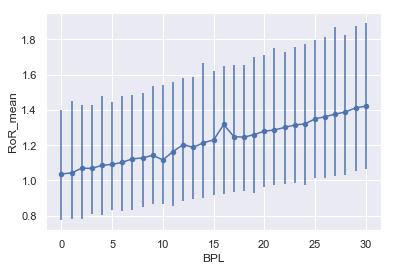

In [43]:
def BPL_control_data(n):
    # setup BPCc support
    BPL_mean = model_data['BPL'].mean()
    BPL_std = model_data['BPL'].std()
    BPL_range = np.linspace(0, n, n+1)
    BPL_range_stdised = (BPL_range - BPL_mean) / BPL_std

    # setup all other numerical variates at average/control levels
    all_other_vars = np.zeros(n+1)

    # setup categorical variabes to be EF auctions for IT
    auction_mech_fix = np.zeros(n+1)
    country_fix = np.zeros(n+1) + 16

    # set values on model variables
    lots.set_value(all_other_vars)
    mean_rsv.set_value(all_other_vars)
    avg_start_bid.set_value(all_other_vars)
    BPL.set_value(BPL_range_stdised)
    auction_mech.set_value(auction_mech_fix.astype('int32'))
    country.set_value(country_fix.astype('int32'))
    start_bids.set_value(all_other_vars.astype('int32'))
    return BPL_range


BPL_support = BPL_control_data(30)

BPL_pp_dist = pm.sample_posterior_predictive(
    ror_robust_trace, model=ror_robust, samples=10000, random_seed=42)['obs']

RoR_pp_mean = label_itfm(BPL_pp_dist.mean(axis=0))

RoR_pp_lwr = (
    RoR_pp_mean
    - label_itfm(np.percentile(BPL_pp_dist, 2.5, axis=0)))

RoR_pp_upr = (
    label_itfm(np.percentile(BPL_pp_dist, 97.5, axis=0))
    - RoR_pp_mean)

BPL_control_df = pd.DataFrame(
    {'BPL': BPL_support, 'RoR_mean': RoR_pp_mean, 'RoR_lwr': RoR_pp_lwr,
     'RoR_upr': RoR_pp_upr})

_ = (BPL_control_df
     .plot(kind='scatter', x='BPL', y='RoR_mean')
     .errorbar(x=BPL_control_df['BPL'], y=BPL_control_df['RoR_mean'],
               yerr=[BPL_control_df['RoR_lwr'], BPL_control_df['RoR_upr']]))

We can see that BPL has a neutral impact on performance - this is somewhat 'off' and needs to be further investigated. Maybe not all bidders are 'serious' and there are a lot of 'noisy' bids that are not contributing the efficiency of the price discovery process.

#### Analysis #3 - Posterior Predictive Check
As a check on the distributional properties of our model, we compare the posterior predictive distribution (below in blue), to the distribution of the test dataset (below orange, overlaid onto the posterior predictive distribution).

100%|██████████| 10000/10000 [02:08<00:00, 77.63it/s]


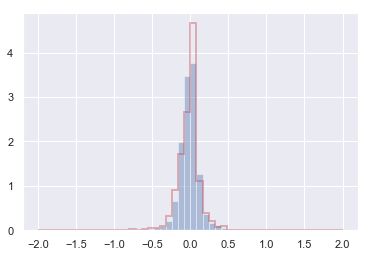

In [44]:
load_train_data()

pp_test_dist = pm.sample_posterior_predictive(
    ror_robust_trace, model=ror_robust, samples=10000, random_seed=42)['obs']

_ = sns.distplot(
    pp_test_dist.ravel(), bins=50, norm_hist=True, kde=False, 
    hist_kws={'range': [-2, 2]})

_ = sns.distplot(
    y_test, bins=50, norm_hist=True, kde=False, 
    hist_kws={'histtype': 'step', 'color': 'r', 'range': [-2, 2],
              'linewidth': 2}, ax=_)

By visual inspection alone, it is possible to see that the distributions are a good match, but that the distribution of the data is more leptokurtic than that of the model's - i.e. the 'tails' of the data are fatter than the Student-T we have used for the likelihood.

## Conclusions
- English Forward auctions are likely to out-perform sealed bid auctions, on average;
- the number of lots offered has a small negative impact on price - e.g adding 100 more lots than usual will reduce prices by ~2.6%, on average;
- the number of bidders per-lot has a stong positive impact on RoR; and,
- there is a lot of variation in regional market micro-structure - e.g the factors that determine supply-and-demand dynamics (how much of what can be sold to whom, given competition), varies considerably on a regional basis.